# 1. Environment and project setup

### Section 1.1: Importing Libraries and GPU Configuration
This block imports necessary libraries for data processing (`os`, `numpy`, `librosa`) and model building using TensorFlow/Keras. It also verifies GPU availability to ensure the system leverages hardware acceleration.


In [38]:
# Import libraries
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import random
from tqdm import tqdm

# Ensure TensorFlow uses GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  0
GPUs Available: []


### Section 1.2: Dataset Path Initialization
Defines paths for the ASVspoof2019 Logical Access dataset (training, validation, and test sets) along with their corresponding protocol files. This setup ensures structured access to audio and label data for preprocessing and model training.

In [39]:
# Dataset paths
DATASET_PATH = "/mnt/c/DF/LA/"
DATASET_TRAIN = os.path.join(DATASET_PATH, "ASVspoof2019_LA_train/flac")  # Path to training audio files
DATASET_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_dev/flac")     # Path to validation audio files
DATASET_UNSEEN_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_eval/flac")   # Path to test audio files

# Label files contain the protocol for bonafide/spoof labels for each audio file
LABELS_TRAIN = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt")
LABELS_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt")
LABELS_UNSEEN_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt")

# Print paths to verify correctness
print("Train Dataset Path:", DATASET_TRAIN)
print("Labels Train Path:", LABELS_TRAIN)

Train Dataset Path: /mnt/c/DF/LA/ASVspoof2019_LA_train/flac
Labels Train Path: /mnt/c/DF/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt


### Section 1.3: Audio Preprocessing Configuration
Defines key parameters for audio preprocessing:
- **Sample rate:** 16 kHz to ensure uniformity.
- **Clip duration:** 5 seconds to standardize input length.
- **Mel bins:** 128 for Mel spectrogram generation.
The number of classes is set to 2 for binary classification (bonafide vs. spoof).

In [40]:
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
N_MELS = 128  # Number of Mel frequency bins
RANDOM_STATE = 2159081 # For reproducibility
MAX_TIME_STEPS = 109  # Define the maximum time steps for your model

random.seed(RANDOM_STATE)  # For reproducibility

# 2. Loading dataset labels
### Section 2.1: Loading Labels from Protocol Files
This block defines and uses a function to load labels from ASVspoof protocol files. Labels are mapped to filenames and stored in a dictionary for easy retrieval. The function processes training, validation, and test datasets, and their label counts and examples are printed for verification.


In [43]:
# Define a function to load labels from the protocol file
def load_labels(file_path):
    labels = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            # Example protocol line: <file_id> <label>
            file_id, filename, label = parts[0], parts[1], parts[-1]
            labels[filename] = label
    return labels

# Load training labels
train_labels = load_labels(LABELS_TRAIN)
test_labels = load_labels(LABELS_TEST)

# Print some examples
print("Number of testing samples:", len(test_labels))
print("Testing example label:", list(test_labels.items())[:5])

Number of testing samples: 24844
Testing example label: [('LA_D_1047731', 'bonafide'), ('LA_D_1105538', 'bonafide'), ('LA_D_1125976', 'bonafide'), ('LA_D_1293230', 'bonafide'), ('LA_D_1340209', 'bonafide')]


In [45]:
from tqdm import tqdm

# Function to load audio files and convert them to Mel spectrograms
def load_dataset_files(dataset_path, dataset_labels):
    """
    Loads audio files from a given dataset path, converts them to Mel spectrograms, 
    and ensures all spectrograms have the same size.

    Args:
        dataset_path (str): Path to the dataset containing audio files.
        dataset_labels (dict): Dictionary mapping file names to their labels.

    Returns:
        X (np.array): Array of Mel spectrograms.
        y (np.array): Array of corresponding labels.
    """
    X = []
    y = []
    
    # Iterate over each file and its label
    for file_name, label in tqdm(dataset_labels.items(), desc="Loading and converting files"):
        file_path = os.path.join(dataset_path, file_name + ".flac")
        
        try:
            # Load audio file with librosa
            audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
            
            # Compute Mel spectrogram
            mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
            mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to decibel scale
            
            # Adjust spectrogram time steps to MAX_TIME_STEPS
            if mel_spectrogram.shape[1] < MAX_TIME_STEPS:
                # Pad if time steps are less than MAX_TIME_STEPS
                mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, MAX_TIME_STEPS - mel_spectrogram.shape[1])), mode='constant')
            else:
                # Trim if time steps exceed MAX_TIME_STEPS
                mel_spectrogram = mel_spectrogram[:, :MAX_TIME_STEPS]
            
            X.append(mel_spectrogram)
            y.append(label)
        
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")
    
    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y

# Load the datasets
print("Loading testing dataset...")
X_train, y_train = load_dataset_files(DATASET_TRAIN, train_labels)
X_test, y_test = load_dataset_files(DATASET_TEST, test_labels)

Loading testing dataset...


Loading and converting files: 100%|███████████████████████████████████████████████| 24844/24844 [08:54<00:00, 46.49it/s]


### Section 2.2: Split training and validation data

In [47]:
split_index = int(0.8 * len(X_train))
X_train, X_val = X_train[:split_index], X_train[split_index:]
y_train, y_val = y_train[:split_index], y_train[split_index:]

# Verify shapes
print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")

Training data shape: (20304, 128, 109), Labels shape: (20304,)
Validation data shape: (5076, 128, 109), Labels shape: (5076,)
Testing data shape: (24844, 128, 109), Labels shape: (24844,)


### Section 3.3: Adjust labelling

In [48]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Map labels from strings to integers
label_mapping = {"bonafide": 0, "spoof": 1}
y_train = np.array([label_mapping[label] for label in y_train])
y_val = np.array([label_mapping[label] for label in y_val])
y_test = np.array([label_mapping[label] for label in y_test])

# Convert integer labels to one-hot encoded format
y_train = to_categorical(y_train, NUM_CLASSES)
y_val = to_categorical(y_val, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

# 3. Creating and training the CNN
### Section 3.1: Define the model

In [49]:
# Define CNN model architecture
input_shape = (N_MELS, X_train.shape[2], 1)  # Input shape for CNN (height, width, channels)
model_input = Input(shape=input_shape)

x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
model_output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=model_input, outputs=model_output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Section 3.2: Train the model

In [50]:
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.9037 - loss: 1.5142 - val_accuracy: 0.1757 - val_loss: 3.6928
Epoch 2/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.9873 - loss: 0.0370 - val_accuracy: 0.2388 - val_loss: 5.6576
Epoch 3/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.9941 - loss: 0.0225 - val_accuracy: 0.2530 - val_loss: 3.3505
Epoch 4/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 39s 59ms/step - accuracy: 0.9915 - loss: 0.0286 - val_accuracy: 0.2214 - val_loss: 6.8530
Epoch 5/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 38s 59ms/step - accuracy: 0.9945 - loss: 0.0176 - val_accuracy: 0.2204 - val_loss: 8.3449
Epoch 6/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.9962 - loss: 0.0150 - val_accuracy: 0.2435 - val_loss: 9.6738
Epoch 7/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 38s 59ms/step - accuracy: 0.9963 - loss: 0.0115 - val_accuracy: 0.2624 - val_loss: 7.2365
Epoch 8/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.9973 - loss: 0.0078 - 

### Section 3.3: Save the model

In [51]:
from datetime import datetime

# Generate a dynamic filename with the current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M")  # Format: YYYYMMDD_HHMM
model_filename = f"CNN_Unbalanced_Model_{current_time}.h5"  # Dynamic model filename

# Save the model
model.save(model_filename)

print(f"Model saved as: {model_filename}")

Model saved as: CNN_Unbalanced_Model_20250119_2207.h5


# 4. Data Visualisation and Testing
### Section 4.1:  Evaluate on test set

777/777 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step


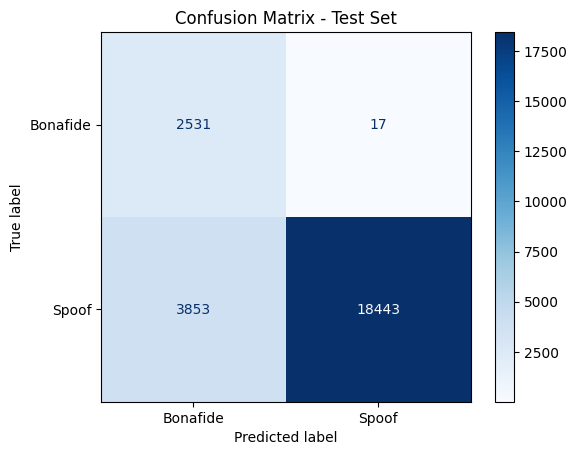

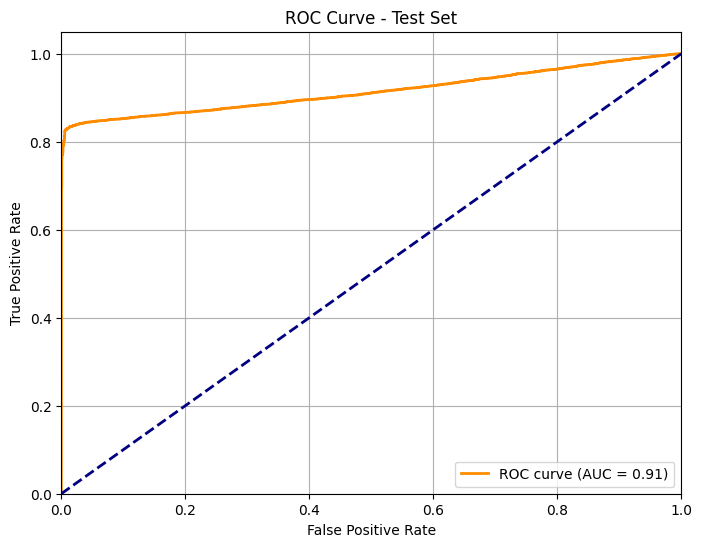

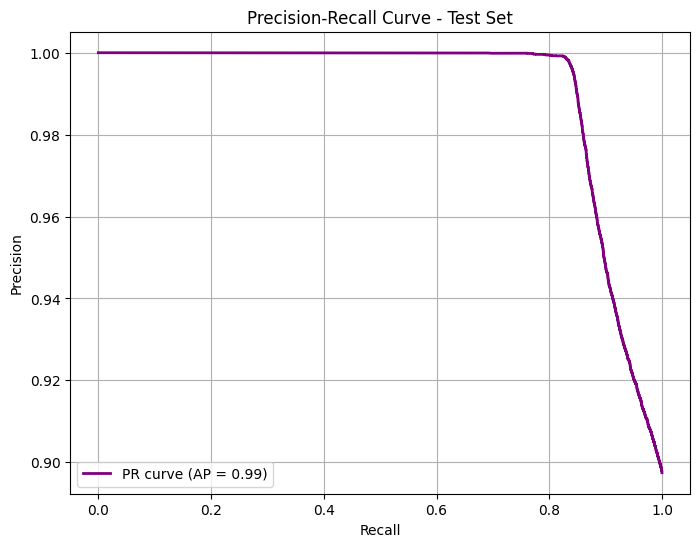

In [52]:
# Load the model and preprocess test data (similar to training data preprocessing)
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

# Predict on the testing set
test_predictions = model.predict(X_test)
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(test_true_classes, test_pred_classes)
ConfusionMatrixDisplay(conf_matrix, display_labels=["Bonafide", "Spoof"]).plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(test_true_classes, test_predictions[:, 1])  # Use the positive class probabilities
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_true_classes, test_predictions[:, 1])
average_precision = average_precision_score(test_true_classes, test_predictions[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f"PR curve (AP = {average_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Test Set")
plt.legend(loc="lower left")
plt.grid()
plt.show()